In [10]:
import numpy as np
import pickle
from matplotlib import pyplot as plt
import matplotlib

def conf_intervals(x,n_train,epochs):
    #Returns per-epoch mean rewards/costs as well as lower and upper bounds assuming normally distributed errors
    #given a list of rewards or cost of length n_train*epochs. If the list is shorter, outputs are filled by NaNs. 
    means = []
    lows = []
    highs = []
    for i in range(len(x)//n_train):
        means.append(np.mean(x[i*n_train:(i+1)*n_train]))
        lows.append(means[i]-1.645*np.std(x[i*n_train:(i+1)*n_train])/np.sqrt(n_train))
        highs.append(means[i]+1.645*np.std(x[i*n_train:(i+1)*n_train])/np.sqrt(n_train))
    while len(means)<epochs:
        means.append(np.nan)
        lows.append(np.nan)
        highs.append(np.nan)
    return np.array(means), np.array(lows), np.array(highs)



def plot(files,legend=[],loc_legend="lower left",epochs=10,fig_legend=2,stretch=1,figsize=(10,3),fontsize=10,n_train=10,n_test=0):
    #Plots costs and rewards. Files is a list of the experiment names stored in the corresponding ...+"costs.pkl" 
    #and ...+"rews.pkl" files in the results folder. 
    #Legend lists the names used for the legend in the same order.
    #Epochs is the maximal amount of training epochs for the experiments (all epochs are 25 episodes). 
    #Fig_legend determines whether the legend is displayed in the cost- or reward-subfigure.
    #Stretch can be used to calculate means and confidence intervals using more than one epoch 
    #(useful for longer experiments). 
    #Figsize determines the overall figure size.
    #Fontsize determines the fontsize used for all text in the plots (legend, axis labels and ticks)
    
    matplotlib.rcParams.update({'font.size': fontsize})
    colors = ["orange","blue","red","green","purple"]
    f, (ax1, ax2) = plt.subplots(1, 2,figsize=figsize)
    
    for color,file in zip(colors[:len(files)],files): 
        #load results
        with open("results/"+file+"costs.pkl", "rb") as input_file:
            costs = pickle.load(input_file)
        with open("results/"+file+"rews.pkl", "rb") as input_file:
            rewards = pickle.load(input_file)
        assert file[:3] in ["ppo","sac","td3"]

        #Create lists for train and test episodes. 
        r_train = []
        r_test = []
        c_train = []
        c_test = []
        
        #write train and test results to the corresponding lists
        for i in range(epochs):
            r_train += rewards[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test]
            c_train += costs[(n_train+n_test)*i:(n_train+n_test)*(i+1)-n_test]
            if file[:3]=="sac" or file[:3]=="td3":
                r_test += rewards[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)]
                c_test += costs[(n_train+n_test)*i+n_train:(n_train+n_test)*(i+1)]
                
        #Create confidence intervals
        avr_train,lowerr_train,upperr_train = conf_intervals(r_train,n_train*stretch,epochs/stretch)
        avc_train,lowerc_train,upperc_train = conf_intervals(c_train,n_train*stretch,epochs/stretch)
        
        #Set axis labels 
        ax1.set_xlabel("Environment interactions")
        ax2.set_xlabel("Environment interactions")
        ax1.set_ylabel("Episode reward")
        ax2.set_ylabel("Episode cost")
        
        #Make sure plots use the same scale
        ax1.set_ylim((-5,35))
        
        #Plot rewards
        x = np.arange(epochs/stretch)*1000*n_train*stretch
        ax1.plot(x,avr_train,color=color)
        ax1.fill_between(x,lowerr_train,upperr_train,alpha=1/2,color=color, label='_nolegend_')
        #Include TRPO results 
        if file.split("_")[-1] not in ["cargoal","pointpush","pointgoal2"]:
            ax1.plot(x,np.zeros(len(x))+2.38398003623805,linestyle="dotted",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+6.122558633103186 ,linestyle="dashdot",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+9.407788493971768 ,linestyle="dashed",color="grey", label='_nolegend_')
            ax1.plot(x,np.zeros(len(x))+17.146432761106485,color="grey", label='_nolegend_')
            if max(x)>=100000:
                ax1.scatter(100000,2.38398003623805,marker="x",color="grey", label='_nolegend_')
            if max(x)>=500000:
                ax1.scatter(500000,6.122558633103186,marker="x",color="grey", label='_nolegend_')
            if max(x)>=1000000:
                ax1.scatter(1000000,9.407788493971768,marker="x",color="grey", label='_nolegend_')
            if max(x)>=10000000:
                ax1.scatter(10000000,17.146432761106485,marker="x",color="grey", label='_nolegend_')
        
        
        #Make sure plots use the same scale
        ax2.set_ylim((-1,50))
        
        #Plot costs
        ax2.plot(x,avc_train,color=color)
        ax2.fill_between(x,lowerc_train,upperc_train,alpha=1/2,color=color, label='_nolegend_')
        ax2.plot(x,np.zeros(int(epochs/stretch))+25,color="k", label='_nolegend_')
        
        #Include TRPO results
        if file.split("_")[-1] not in ["cargoal","pointpush","pointgoal2"]:
            ax2.plot(x,np.zeros(len(x))+32.517591154162474,linestyle="dotted",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+28.651618995400412 ,linestyle="dashdot",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+21.432270248865336 ,linestyle="dashed",color="grey", label='_nolegend_')
            ax2.plot(x,np.zeros(len(x))+25.806451612903246,color="grey", label='_nolegend_')
            if max(x)>=100000:
                ax2.scatter(100000,32.517591154162474,marker="x",color="grey", label='_nolegend_')
            if max(x)>=500000:
                ax2.scatter(500000,28.651618995400412,marker="x",color="grey", label='_nolegend_')
            if max(x)>=1000000:
                ax2.scatter(1000000,21.432270248865336,marker="x",color="grey", label='_nolegend_')
            if max(x)>=10000000:
                ax2.scatter(10000000,25.806451612903246,marker="x",color="grey", label='_nolegend_')
        #Add legend
        if fig_legend==2:
            ax2.legend(legend, loc=loc_legend)
        else:
            ax1.legend(legend, loc=loc_legend)
        
        #print("rews",avc_train)
        #print("costs",avc_train)

rews [35.6 28.9 84.2 75.4 36.  47.  30.3 13.7 26.   0. ]
rews [ 0.  21.3 82.7 54.9 31.6  5.2 35.9 21.6 35.   9.6]
rews [45.4 42.6 66.   9.7  8.7 26.4 21.7 29.8  1.9  5.7]
rews [ 97.2  54.6 146.1  66.   34.1  73.4  22.8   0.    1.1   5.7]


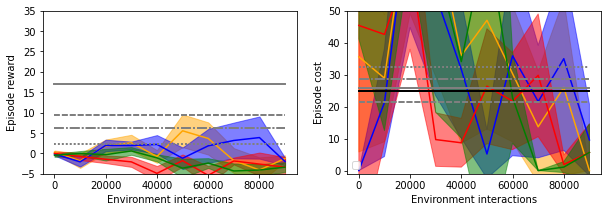

In [11]:
plot(["sac_b10_m0","sac_b1_m0","sac_b10","sac_b1"],epochs=10)